In [1]:
import os
import numpy
from scipy.misc import logsumexp
import tqdm
import pickle
import hom2m
import wendy
import wendym2m
from galpy.util import bovy_plot, save_pickles
%pylab inline
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
numpy.random.seed(4)
import copy
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML, Image
import seaborn as sns
tc= sns.color_palette('colorblind')
init_color= sns.color_palette()[0]
final_color= tc[2]
constraint_color= tc[1]
save_figures= True
save_chain_figures= False
_SAVE_GIFS= False
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17.,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': _SAVE_GIFS,
              'figure.figsize': [5,5],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1})
import copy
numpy.random.seed(2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%aimport wendym2m
%autoreload 1

# M2M with one-dimensional self-gravity with an external potential

Here we investigate M2M with one-dimensional self-gravity and a constant density background.

## Mock observations


First we generate some mock observations for a self-gravitating isothermal disk (a $\mathrm{sech}^2$ disk) with a constant background. A well-known solution of the one-dimensional N-body system is a $\mathrm{sech}^2$ disk. This is the equilibrium distribution for a disk with an isothermal Gaussian velocity distribution (that is, a velocity distribution that is Gaussian with the same dispersion at all locations). Because the equilibrium distribution can only be a function of the energy $E = \Phi(x)+v^2/2$ and the velocity distribution is required to be Gaussian, $f(v) \propto e^{-v^2/[2\sigma^2]}$, the equilibrium distribution function is by necessity:

$f(x,v) = \frac{\rho_0}{\sqrt{2\pi}\,\sigma}\,e^{-E/\sigma^2} = \frac{\rho_0}{\sqrt{2\pi}\,\sigma}\,e^{-\Phi(x)/\sigma^2-v^2/[2\sigma^2]}\,,$

with density

$\rho(x) = \rho_0\,e^{-\Phi(x)/\sigma^2}\,.$

Plugging this density into the Poisson equation allows us to solve for the potential:

$\frac{\mathrm{d}^2\Phi(x)}{\mathrm{d}x^2} = 4\pi G \rho(x) = 4\pi G \rho_0\,e^{-\Phi(x)/\sigma^2}\,,$

which has the solution

$\Phi(x) = 2\sigma^2 \ln\left(\mathrm{cosh}\left[\frac{x}{2 H}\right]\right)\,,$

with $H^2 = \sigma^2/[8\pi G \rho_0]$, because

$\frac{\mathrm{d}\Phi(x)}{\mathrm{d}x} = \frac{2 \sigma^2}{2 H} \frac{\mathrm{sinh}\left[\frac{x}{2 H}\right]}{\mathrm{cosh}\left[\frac{x}{2 H}\right]} = \frac{2 \sigma^2}{2 H}  \mathrm{tanh}\left[\frac{x}{2 H}\right]$, $\frac{\mathrm{d}^2\Phi(x)}{\mathrm{d}x^2} = \frac{2 \sigma^2}{4 H^2} \mathrm{sech}^2\left[\frac{x}{2 H}\right]$

Alternatively, $H = \sigma^2 / [2\pi G \Sigma]$, where $\Sigma$ is the total surface density. The density is then

$\rho(x) = \rho_0\,\mathrm{sech}^2\left(\frac{x}{2H}\right)\,$

and
 
$\Sigma = \int^{\infty}_{-\infty} \rho_0 \mathrm{sech}^2\left[\frac{x}{2 H}\right] dx = 4 H \rho_0$.

We set $\Sigma=1.0$ and $\sigma=0.5$, and therefore with $2 \pi G=1$ unit, $H=0.25$ and $\rho0=1$. 

For an external potential, we consider that in the solar neighborhood dark matter is an approximately constant density $\rho_{\mathrm{DM}} = $ constant.

This density corresponds to a potential $\Phi_{\mathrm{DM}} = \omega^2 x^2 / 2$, with $\omega = \sqrt{4\pi\,G\,\rho_{\mathrm{DM}}}$.

We set $\rho_{\mathrm{DM}}=1$, i.e. equivalent to the disk mass, and therfore $\omega = 1/\sqrt{2}$. 

In [3]:
n_init = 100000
n_init0 = n_init
sigma_true = 0.5
totmass_true = 1.0
zh_true = sigma_true**2./totmass_true
tdyn = zh_true/sigma_true
# external potential
omegadm_true = 1.0/numpy.sqrt(2.0)
z_init, vz_init, m_init = wendym2m.sample_sech2(
    sigma_true, totmass_true, n=n_init)
print('zh, tdyn, omega_dm =', zh_true, tdyn, omegadm_true)

zh, tdyn, omega_dm = 0.25 0.5 0.7071067811865475


We will add the background potential adiabatically.

In [4]:
g = wendy.nbody(z_init, vz_init, m_init, 0.05*tdyn, approx=True, nleap=1)

In [5]:
nt = 1000
zt = numpy.empty((n_init, nt+1))
vzt = numpy.empty((n_init, nt+1))
Et = numpy.empty((nt+1))
zt[:, 0] = z_init
vzt[:, 0] = vz_init
Et[0] = wendy.energy(z_init, vz_init, m_init)
# increasing omega
nstep_omega = 500
domega = omegadm_true/nstep_omega
omega_ii = 0.0
tz = z_init
tvz = vz_init
for ii in tqdm.trange(nt):
    if ii <= nstep_omega:
        g = wendy.nbody(tz, tvz, m_init, 0.05*tdyn, omega=omega_ii, approx=True, nleap=1)
    tz, tvz= next(g)
    zt[:, ii+1] = tz
    vzt[:, ii+1] = tvz
    Et[ii+1] = wendy.energy(tz, tvz, m_init, omega=omega_ii)
    # update omega
    if ii < nstep_omega:
        omega_ii += domega
z_start= zt[:, -1]
vz_start= vzt[:, -1]
print('Final omega and omega_dm =', omega_ii, omegadm_true)

100%|██████████| 1000/1000 [01:19<00:00, 29.52it/s]

Final omega and omega_dm = 0.7071067811865535 0.7071067811865475


In [6]:
figsize(6,4)
fig, ax = subplots()
ii = 0
# plot range 
zmin = -2.0
zmax = 2.0
rhomin = 10.**-3.
rhomax = 1.2
nbinz = 101
a = ax.hist(zt[:,ii], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = nbinz/(zmax-zmin)/n_init*numpy.ones(n_init))
zs = numpy.linspace(zmin, zmax, nbinz)
ax.plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
ax.set_xlim(zmin, zmax)
ax.set_ylim(rhomin, rhomax)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.set_yscale('log')
ax.annotate(r'$t=0$', (0.95,0.95), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            size=18.)
subsamp= 5
def animate(ii):
    ax.clear()
    norm = 1./n_init
    a = ax.hist(zt[:, ii*subsamp], bins=nbinz, histtype='step',
                lw=1., color='k', range=[zmin, zmax],
                weights=nbinz/(zmax-zmin)/n_init*numpy.ones(n_init))
    zs = numpy.linspace(zmin, zmax, nbinz)
    ax.plot(zs, 
            totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
    ax.set_xlim(zmin, zmax)
    ax.set_ylim(rhomin, rhomax)
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$\rho(z)$')
    #ax.set_yscale('log')
    ax.annotate(r'$t=%.0f$' % (ii*subsamp/20.),
                (0.95,0.95), xycoords='axes fraction',
                horizontalalignment='right',
                verticalalignment='top', size=18.)
    return a[2]
anim = animation.FuncAnimation(
    fig, animate,#init_func=init_anim_frame,
    frames=nt//subsamp, interval=40, blit=True, repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

After the external potential in introduced, the density profile is more centrally concentrated.

We will set up the target using at step=1000.

In [7]:
# selected step
istep = 1000
n_mock = n_init
z_mock = copy.deepcopy(z_start)
vz_mock = copy.deepcopy(vz_start)
m_mock = copy.deepcopy(m_init)
totmass_true = numpy.sum(m_mock)
omegadm = copy.deepcopy(omegadm_true)
print('Totmass =', totmass_true) 

Totmass = 1.0


Let's plot the density profile. 

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



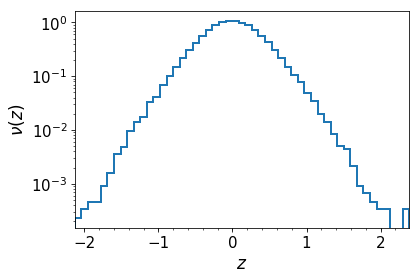

In [8]:
_= bovy_plot.bovy_hist(z_mock,bins=51,normed=True,
                       xlabel=r'$z$',ylabel=r'$\nu(z)$',lw=2.,
                       histtype='step')
gca().set_yscale('log')

Now we 'observe' this density distribution from $z_{\mathrm{sun}} = 0.05$:

In [9]:
zsun_true= 0.05
# We only observe the density at a few z
# z_obs= numpy.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0,
#                    0. -0.2, -0.4, -0.6, -0.8, -1.0, -1.2,
#                    -1.4, -1.6, -1.8, -2.0])
z_obs= numpy.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 
                   -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0])
h_obs= 0.2
dens_obs= hom2m.compute_dens(z_mock,zsun_true,z_obs,h_obs,w=m_mock)
dens_obs_noise= numpy.sqrt(dens_obs)*0.2*numpy.sqrt(numpy.amax(dens_obs))\
    /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
dens_obs+= numpy.random.normal(size=dens_obs.shape)*dens_obs_noise

The observed density is:

<ErrorbarContainer object of 3 artists>

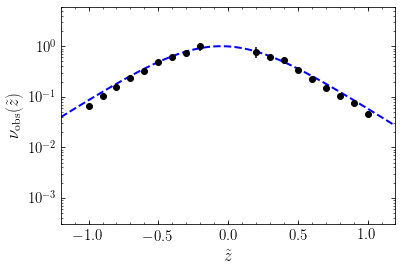

In [10]:
zmin = -1.2
zmax = 1.2
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax], yrange=[0.0003,6.])
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean of the squared velocity:

In [11]:
# We only observe the v2 at a few z (same as before)
v2_obs= hom2m.compute_v2(z_mock,vz_mock,zsun_true,z_obs,h_obs)
# use constant noise
v2_obs_noise=numpy.zeros_like(v2_obs)+0.002
numpy.random.seed(10) # probably best to set a seed somewhere so the data is always the same
v2_obs+= numpy.random.normal(size=v2_obs.shape)*v2_obs_noise

<ErrorbarContainer object of 3 artists>

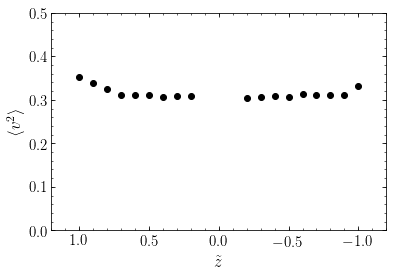

In [12]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v2_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[zmax, zmin],yrange=[0.0,0.5],gcf=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color='k')

Now we load all of this data into the ``data_dicts`` format for specifying the data for M2M:

In [13]:
dens_data= {'type':'dens','pops':0,'zobs':z_obs,'obs':dens_obs,'unc':dens_obs_noise,'zrange':1.}
v2_data= {'type':'v2','pops':0,'zobs':z_obs,'obs':v2_obs,'unc':v2_obs_noise,'zrange':1.}
data_dicts= [dens_data,v2_data]

## M2M fit

We will fit the density and velocity profiles with Wendy M2M with known $z_{\odot}$ and $\omega_{DM}$.

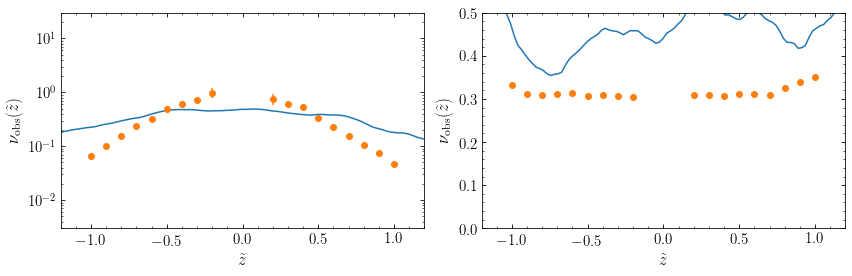

In [14]:
n_m2m= 1000
sigma_init= 0.7
h_m2m= 0.2
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_true,n=n_m2m)
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.003,30.])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.0,0.5])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
tight_layout()

Run without any smoothing:

In [15]:
import wendym2m
# step size for particle integration
step= 0.05*tdyn
nstep= 4000
#eps= 10.**-3.5
eps = 10.0**-6.0
smooth= None #1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.2
omega_m2m= omegadm_true
zsun_m2m= zsun_true
prior= 'entropy'
use_v2=True
w_out,z_m2m,vz_m2m,Q,wevol,windx= \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=10)
w_out= w_out[:,0]

 total mass = 0.8518479717413684
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

Velocity dispersions: mock, fit 0.5547765406731276 0.5571636088344846
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid li

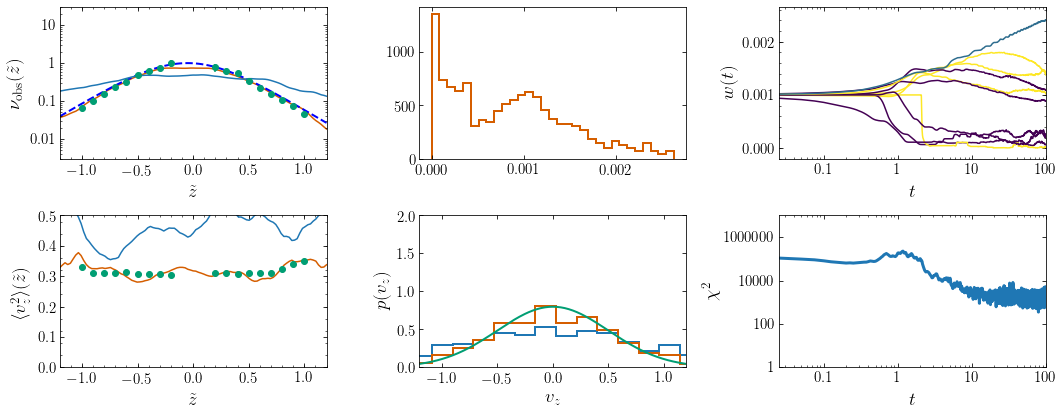

In [16]:
print(' total mass =', numpy.sum(w_out))
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[0.0,0.5],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
#_= hist(w_init,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
_= hist(w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(zmin, zmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(zmin, zmax)
ylim(0.,2.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
                        color=cm.viridis(z_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

We can also look at how the fit converges with a movie:

In [21]:
# Require output of position and velocity...
step= 0.05*tdyn
nstep= 4000
# eps= 10.**-3.5
eps = 10.0**-6.0
smooth= None #1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.2
omega_m2m= omegadm_true
zsun_m2m= zsun_true
prior= 'entropy'
use_v2=True
w_out,z_m2m,vz_m2m,Q,wevol,windx, zevol, vzevol = \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=len(w_init),
                     output_zvzevolution=len(w_init))

In [ ]:
figsize(12,4)
fig, (ax1, ax2) = pyplot.subplots(1,2)
subplot(1,2,1)
line1, = pyplot.plot([],[],lw=2)
subplot(1,2,2)
line2, = pyplot.plot([],[],lw=2)
line= [line1,line2]
subplots_adjust(wspace=.25)
def init_anim_frame():
    subplot(1,2,1)
    line1= bovy_plot.bovy_plot(
        z_out,dens_init,'-',semilogy=True,color=init_color,
        xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
        xrange=[zmin, zmax],yrange=[0.003, 30.],gcf=True)
    line2= bovy_plot.bovy_plot(
        z_obs, dens_obs, 'o', semilogy=True, overplot=True, color=constraint_color)
    line3= errorbar(
        z_obs, dens_obs, yerr=dens_obs_noise, marker='None',
        ls='none', color=constraint_color)
    subplot(1,2,2)
    line4= bovy_plot.bovy_plot(
        z_out, v2_init, '-', color=init_color,
        xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle$',
        xrange=[zmin, zmax],yrange=[0.0,0.5],gcf=True)
    line5= bovy_plot.bovy_plot(z_obs, v2_obs, 'o', overplot=True, color=constraint_color)
    line6= errorbar(
        z_obs, v2_obs, yerr=v2_obs_noise, marker='None', ls='none',color=constraint_color)
    return (line1[0],line2[0],line3[0],line4[0],line5[0],line6[0])

subsamp= 5
ipop = 0
def animate(ii):
    ax.clear()
    dens_final = hom2m.compute_dens(zevol[:, ii*subsamp], zsun_true, z_out, h_m2m, w=wevol[:, ipop, ii*subsamp])
    line[0].set_data(z_out, dens_final)
    line[1].set_color(color=final_color)
    v2_final = hom2m.compute_v2(zevol[:, ii*subsamp], vzevol[:, ii*subsamp], zsun_true, z_out,
                                h_m2m, w=wevol[:, ipop, ii*subsamp])
    line[1].set_data(z_out, v2_final)
    line[1].set_color(color=final_color)
    return line
anim = animation.FuncAnimation(
    fig, animate, init_func=init_anim_frame,
    frames=nt//subsamp, interval=40, blit=True, repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

## Fitting for $\omega$

In [32]:
n_m2m= 4000
sigma_init= 0.7
h_m2m= 0.2
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_true,n=n_m2m)
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)

In [33]:
# step size for particle integration
step= 0.05*tdyn
nstep= 4000
#eps= 10.**-3.5
eps = [10.0**-5.0, 10.0**-5.0]
smooth= None #1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.2
zsun_m2m= zsun_true
omega_m2m = 1.5*omegadm_true
fit_omega = True
skipomega= 10
prior= 'entropy'
use_v2=True
w_out,omega_out,z_m2m,vz_m2m,Q,wevol,windx= \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=10,
                     fit_omega=fit_omega,skipomega=skipomega)
w_out= w_out[:,0]

 total mass = 0.923622251328554
 omega =  0.7249748159912827
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

Velocity dispersions: mock, fit 0.5547765406731276 0.5531380051356659
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits fo

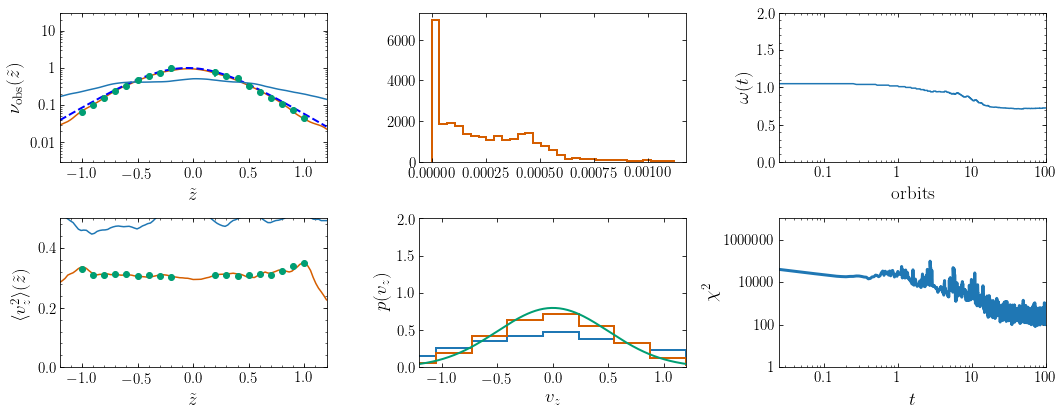

In [34]:
print(' total mass =', numpy.sum(w_out))
print(' omega = ', omega_out[-1])
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[0.0,0.5],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
#_= hist(w_init,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
_= hist(w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(zmin, zmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(zmin, zmax)
ylim(0.,2.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,2.],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True)
print("omega: best-fit",omega_out[-1])
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
# for ii in range(len(wevol)):
#    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
#                        color=cm.viridis(z_m2m[windx][ii]/0.3),
#                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
#                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()